# 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import math
import pandas as pd 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import optuna
from sklearn.model_selection import cross_val_score
import math 
data = pd.read_csv("../Data/D-FENSE/merged_d-fense.csv")

print(data.head(6))

   epiweek  cases   temp_min   temp_med   temp_max  precip_min  precip_med  \
0   201001   3539  21.658084  25.004341  29.274303    0.012281    0.302680   
1   201001     22  24.048092  26.776109  30.772313    0.002407    0.082629   
2   201001    208  23.877589  26.699426  30.751801    0.015402    0.285009   
3   201001   4256  22.527846  25.419562  29.649180    0.021887    0.373958   
4   201001    210  22.065314  25.423990  29.700304    0.003048    0.076435   
5   201001     75  23.267653  26.596911  30.972213    0.000440    0.061565   

   precip_max   precip_tot region  
0    1.230068  1128.998094     SP  
1    0.371142    41.649765     SE  
2    1.101980   367.566872     PA  
3    1.414037   484.254513     MT  
4    0.324229   105.137269     PE  
5    0.317397     9.340346     RR  


/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Encoding / Rescaling

In [2]:
# convert to log-scale
data['cases'] = np.log1p(data['cases'])

In [3]:
# apply encodings
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# data['region'] = one_hot_encoder.fit_transform(data.loc[:, ['region']])
label_encoder = LabelEncoder()
data['region'] = label_encoder.fit_transform(data.loc[:, ['region']])


/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Feature Engineering
- Cosine Weeks

In [4]:
def week_to_cosine(week : int):
    return np.sin((2 * np.pi)/52  * week)

In [5]:
data['year'] = data['epiweek']//100
data['week'] = data['epiweek']%100
data['week_cosine'] = week_to_cosine(data['epiweek']%100)

#data = data.drop(columns=['epiweek'])
print(data)

       epiweek     cases   temp_min   temp_med   temp_max  precip_min  \
0       201001  8.171882  21.658084  25.004341  29.274303    0.012281   
1       201001  3.135494  24.048092  26.776109  30.772313    0.002407   
2       201001  5.342334  23.877589  26.699426  30.751801    0.015402   
3       201001  8.356320  22.527846  25.419562  29.649180    0.021887   
4       201001  5.351858  22.065314  25.423990  29.700304    0.003048   
...        ...       ...        ...        ...        ...         ...   
16843   202152  0.000000  20.986947  23.801605  27.574272    0.031757   
16844   202152  4.919981  22.985219  25.161822  28.945216    0.019202   
16845   202152  3.218876  23.911944  26.883168  30.797925    0.012379   
16846   202152  4.867534  22.806426  25.650138  29.584844    0.015768   
16847   202152  4.174387  24.052891  27.203483  31.517052    0.000000   

       precip_med  precip_max   precip_tot  region  year  week   week_cosine  
0        0.302680    1.230068  1128.998094  

In [6]:
# lag features

# find for 13 weeks in the past
#for i in range(1, 14):
#    temp_df = data.copy()[['region', 'year', 'week', 'cases']]
#    temp_df['week'] = temp_df['week'] - i
#    #temp_df['week'] = ((temp_df['week'] - i - 1) % 52) + 1
#    temp_df = temp_df.rename(columns={'cases': f'lag_{i}'})
#    data = data.merge(
#        temp_df[['region', 'year', 'week', f'lag_{i}']],
#        on=['region', 'year', 'week'],
#        how='left'
#    )


In [7]:
# train, test, validate split
# this is a split for time-series data.
n_size = data.shape[0]
x_train = data.drop(columns=['cases'])[:int(0.7 * n_size)]
y_train = data['cases'][:int(0.7 * n_size)]
x_val = data.drop(columns=['cases'])[int(0.7 * n_size):int(0.85 * n_size)]
y_val = data['cases'][int(0.7 * n_size):int(0.85 * n_size)]
x_test = data.drop(columns=['cases'])[int(0.85 * n_size):]
y_test = data['cases'][int(0.85 * n_size):]



# alternate split test
# x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['cases']), data["cases"], test_size=.15)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.175)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(11793, 12)
(11793,)
(2528, 12)
(2528,)
(2527, 12)
(2527,)


In [8]:
#def create_lag(data, row, lagnum):
#    target_map = data[data['region'] == row['region']]
#    target_year = row['year']
#    target_week = row['week'] - lagnum
#    if (target_week < 1):
#        target_week =((target_week - lagnum - 1) % 52) + 1
#        target_year -= 1
#    exp_case = target_map[(target_map['week'] == target_week) & (target_map['year'] == target_year)]
#    if exp_case.empty:
#        return np.nan
#    else:
#        return float(exp_case['cases'])

def create_lag(xdf, ydf):
    ydf_index_start = ydf.index.tolist()[0]
    for i in range(1,14):
        #
        for index, row in xdf.iterrows():
            exp_row_week = row['week'] - i 
            exp_row_year = row['year']
            exp_row_region = row['region']
            if exp_row_week < 1:
                exp_row_week = int(((exp_row_week - i - 1) % 52) + 1)
                exp_row_year -= 1
            exp_row = xdf[(xdf['week'] == exp_row_week) & (xdf['year'] == exp_row_year) & (xdf['region'] == exp_row_region)]
            #print(index, exp_row_week, exp_row_year, exp_row_region, exp_row.empty)
            #print("> ", exp_row.index, ydf.iloc[exp_row.index], ydf.iloc[exp_row.index].empty)
            if exp_row.empty:
                xdf.at[index, f'lag_{i}'] = np.nan
            else:
                exp_index = exp_row.index - ydf_index_start
                xdf.at[index, f'lag_{i}'] = float(ydf.iloc[exp_index].iloc[0])

In [9]:

create_lag(x_train, y_train)
create_lag(x_val, y_val)
create_lag(x_test, y_test)

# Hyperparameter Tuning

In [10]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    objective = "reg:squarederror"
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, objective=objective, random_state=42)
    score = np.mean(cross_val_score(model, x_train,y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1))
    return score

    #model.fit(x_train, y_train)
    #y_pred = model.predict(x_test)
    #rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    #return rmse

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)



[I 2025-04-09 16:49:07,224] A new study created in memory with name: no-name-303cb14a-0464-4538-aa6c-77419551a1d7
/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:49:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:49:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:49:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-pack

In [11]:

print(study.best_params)
# Train final model with best parameters
bst = xgb.XGBRegressor(**study.best_params, random_state=42)

{'n_estimators': 119, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 1}


# Model Training

In [12]:
# setup model for XGboost 
bst.fit(x_train,y_train)



/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, min_samples_leaf=1,
             min_samples_split=12, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=119, ...)

[5.6919265 5.030809  5.3531947 5.094168  5.918199  5.679511  7.2860193
 6.9925704 6.3725724 5.661022 ]
[7.7102051944325325, 1.0986122886681096, 8.039157390473237, 5.771441123130016, 4.672828834461906, 7.823245690685523, 5.003946305945459, 4.219507705176107, 7.312553498102598, 4.499809670330265]
mean absolute : 0.3069659001870349
RMSE : 0.7496279180231993
mean squared : 0.5619420154797964
r2 score: 0.8516691796462914


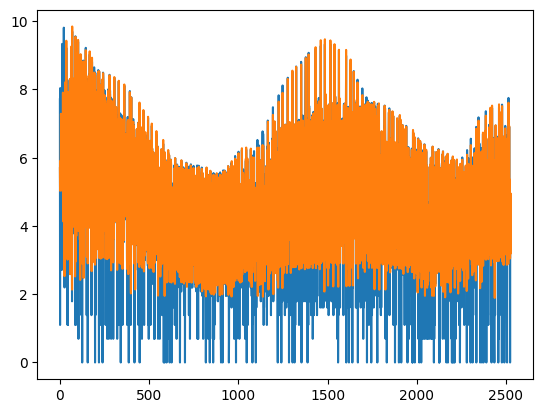

In [13]:
preds = bst.predict(x_test)
print(preds[0:10])
print(list(y_test)[0:10])
print(f"mean absolute : {mean_absolute_error(y_test, preds)}")
print(f"RMSE : {root_mean_squared_error(y_test, preds)}")
print(f"mean squared : {mean_squared_error(y_test, preds)}")
print(f"r2 score: {r2_score(y_test,preds)}")
plt.plot(np.arange(y_test.shape[0]), y_test)
plt.plot(np.arange(preds.shape[0]), preds)

[5.6919265 5.030809  5.3531947 5.094168  5.918199  5.679511  7.2860193
 6.9925704 6.3725724 5.661022 ]
[7.7102051944325325, 1.0986122886681096, 8.039157390473237, 5.771441123130016, 4.672828834461906, 7.823245690685523, 5.003946305945459, 4.219507705176107, 7.312553498102598, 4.499809670330265]
mean absolute : 48.91098650233655
RMSE: 457.91192346029703
mean squared : 209683.3296471089
r2 score: 0.8486511305186557


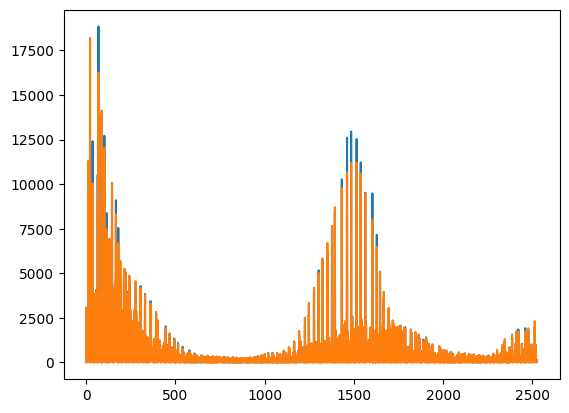

In [14]:
origpreds = np.expm1(preds)
origytest = np.expm1(y_test)
print(preds[0:10])
print(list(y_test)[0:10])
print(f"mean absolute : {mean_absolute_error(origytest, origpreds)}")
print(f"RMSE: {root_mean_squared_error(origytest, origpreds)}")
print(f"mean squared : {mean_squared_error(origytest, origpreds)}")
print(f"r2 score: {r2_score(origytest,origpreds)}")

plt.plot(np.arange(origpreds.shape[0]), origpreds)
plt.plot(np.arange(origytest.shape[0]), origytest)


In [15]:
bst.save_model("xgboostmodel.json")